# 🚀 Mô Hình Dự Báo Giá Bitcoin Với BiLSTM

Notebook này hướng dẫn bạn từng bước để xây dựng và huấn luyện mô hình dự báo giá Bitcoin.

---

## 📋 Checklist

- [ ] Bước 1: Lấy dữ liệu từ Binance
- [ ] Bước 2: Xử lý dữ liệu
- [ ] Bước 3: Xây dựng model BiLSTM
- [ ] Bước 4: Training model
- [ ] Bước 5: Đánh giá & Vẽ biểu đồ

---

## 💡 Tips

1. Chạy từng cell theo thứ tự từ trên xuống dưới
2. Đọc comments trong code để hiểu
3. Nếu cần giải thích chi tiết, xem `docs/` folder
4. Nghỉ giải lao nếu cảm thấy ngợp!

## 📦 0. Setup & Cấu Hình

Cấu hình TensorFlow và import các thư viện cần thiết.

In [61]:
# Import thư viện
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import modules từ project
# Note: Notebook đang chạy từ notebooks/, cần up 1 cấp để tới project root
import sys
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

from utils.runtime import configure_tensorflow_runtime, print_tensorflow_info

# Cấu hình TensorFlow cho CPU AMD
configure_tensorflow_runtime(
    intra_op_threads=12,
    inter_op_threads=2,
    enable_xla=True
)

# In thông tin TensorFlow
print_tensorflow_info()

⚙️  CẤU HÌNH TENSORFLOW RUNTIME
Intra-op threads: 12
Inter-op threads: 2
XLA enabled: True
CPU only: True


📋 THÔNG TIN TENSORFLOW
TensorFlow version: 2.20.0
Keras version: 3.13.0
Built with CUDA: True
ℹ️  Không tìm thấy GPU, sẽ dùng CPU
GPU available: False
Intra-op threads: 12
Inter-op threads: 2



## 🔧 1. Cấu Hình Tham Số

Thay đổi các tham số tùy ý:

In [62]:
# ==================== CẤU HÌNH ====================

# Data parameters
SYMBOL = "BTC/USDT"        # Cặp giao dịch
TIMEFRAME = "4h"           # Khung thời gian (1d, 4h, 1h)
LIMIT = 1500                # Số nến lấy từ Binance
REFRESH_CACHE = False       # True = tải lại data, False = dùng cache

# Preprocessing parameters
WINDOW_SIZE = 100            # Số nến nhìn lại (sliding window)
FEATURES = ["close"]       # Features sử dụng

# Model parameters
LSTM_UNITS = [64, 32]       # Số units cho mỗi LSTM layer
DROPOUT_RATE = 0.2         # Dropout rate

# Training parameters
EPOCHS = 20                 # Số epochs
BATCH_SIZE = 32             # Batch size
EARLY_STOPPING_PATIENCE = 5 # Số epochs chờ trước khi dừng

# Print cấu hình
print("="*60)
print("⚙️  CẤU HÌNH")
print("="*60)
print(f"Symbol: {SYMBOL}")
print(f"Timeframe: {TIMEFRAME}")
print(f"Limit: {LIMIT}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Features: {FEATURES}")
print(f"LSTM units: {LSTM_UNITS}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print("="*60 + "\n")

⚙️  CẤU HÌNH
Symbol: BTC/USDT
Timeframe: 4h
Limit: 1500
Window size: 100
Features: ['close']
LSTM units: [64, 32]
Dropout: 0.2
Epochs: 20
Batch size: 32



---

## 📥 BƯỚC 1: LẤY DỮ LIỆU TỪ BINANCE

### Giải thích:
- Tải dữ liệu giá từ Binance API
- Cache vào file CSV để lần sau không phải tải lại
- Trả về DataFrame với: datetime, open, high, low, close, volume

In [63]:
from step1_data import fetch_binance_data

# Tải dữ liệu
df = fetch_binance_data(
    symbol=SYMBOL,
    timeframe=TIMEFRAME,
    limit=LIMIT,
    save_cache=not REFRESH_CACHE
)

# In 5 dòng đầu tiên
print("\n📊 5 dòng đầu tiên của dữ liệu:")
print(df.head())

# Thống kê cơ bản
print("\n📊 Thống kê dữ liệu:")
print(df.describe())

# Đánh dấu checklist
print("\n✅ Bước 1 hoàn thành!")

📂 Đang đọc dữ liệu từ cache: /home/ultimatebrok/Downloads/deep_learning/step1_data/cache/BTC_USDT_4h_1500.csv

📊 5 dòng đầu tiên của dữ liệu:
             datetime       open       high        low      close  \
0 2025-07-10 16:00:00  111408.40  113788.23  111322.32  113301.81   
1 2025-07-10 20:00:00  113301.80  116868.00  113270.98  116010.00   
2 2025-07-11 00:00:00  116010.01  116950.00  115222.22  116881.70   
3 2025-07-11 04:00:00  116881.69  118404.22  116500.00  117526.88   
4 2025-07-11 08:00:00  117526.88  118869.98  117526.88  117821.91   

         volume  
0   7461.037691  
1  10438.553844  
2   4456.671301  
3   7940.173377  
4   4664.061610  

📊 Thống kê dữ liệu:
                            datetime           open           high  \
count                           1000    1000.000000    1000.000000   
mean   2025-10-01 22:00:00.000000256  107988.849540  108585.073110   
min              2025-07-10 16:00:00   82309.670000   84586.620000   
25%              2025-08-21 07:00:

### Vẽ biểu đồ lịch sử giá

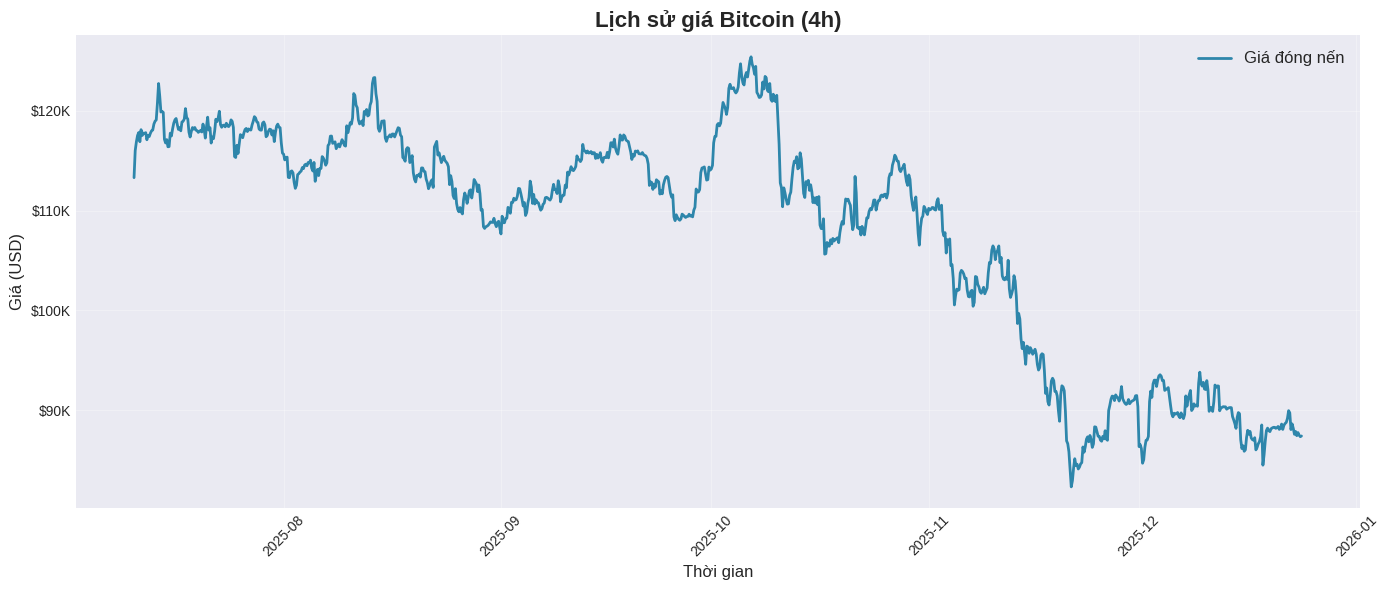

In [64]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(14, 6))
plt.plot(df['datetime'], df['close'], linewidth=2, color='#2E86AB', label='Giá đóng nến')
plt.title(f'Lịch sử giá Bitcoin ({TIMEFRAME})', fontsize=16, fontweight='bold')
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('Giá (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
plt.tight_layout()
plt.show()

---

## 🔨 BƯỚC 2: XỬ LÝ DỮ LIỆU

### Giải thích:
- **Scaling**: Đưa dữ liệu về khoảng [0, 1] để model học tốt hơn
- **Sliding Window**: Tạo sequences (60 ngày trước → dự đoán ngày tiếp theo)
- **Split Data**: Chia thành train (80%), val (10%), test (10%)

In [65]:
from step2_preprocessing import prepare_data_for_lstm

# Pipeline xử lý dữ liệu hoàn chỉnh
data_dict = prepare_data_for_lstm(
    df=df,
    features=FEATURES,
    window_size=WINDOW_SIZE,
    scaler_type='minmax'
)

# Lấy các biến
X_train = data_dict['X_train']
y_train = data_dict['y_train']
X_val = data_dict['X_val']
y_val = data_dict['y_val']
X_test = data_dict['X_test']
y_test = data_dict['y_test']
scaler = data_dict['scaler']

# Đánh dấu checklist
print("\n✅ Bước 2 hoàn thành!")

📦 Dữ liệu gốc shape: (1000, 1)
✅ Đã fit và transform dữ liệu với minmax scaler
   Min: 0.0000, Max: 1.0000
✅ Đã tạo 900 windows:
   X shape: (900, 100, 1) (samples, window_size, features)
   y shape: (900, 1, 1) (samples, predict_steps)
📊 Chia dữ liệu:
   Train: 720 samples (80.0%)
   Val: 90 samples (10.0%)
   Test: 90 samples (9.999999999999995%)

✅ Bước 2 hoàn thành!


### Kiểm tra shapes của dữ liệu

In [66]:
print("\n" + "="*60)
print("📊 SHAPES CỦA DỮ LIỆU")
print("="*60)
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")
print("="*60 + "\n")


📊 SHAPES CỦA DỮ LIỆU
X_train: (720, 100, 1)
y_train: (720, 1, 1)
X_val:   (90, 100, 1)
y_val:   (90, 1, 1)
X_test:  (90, 100, 1)
y_test:  (90, 1, 1)



---

## 🧠 BƯỚC 3: XÂY DỰNG MODEL BiLSTM

### Giải thích:
- **BiLSTM**: LSTM hai chiều (nhìn cả quá khứ và tương lai)
- **Dropout**: Bỏ ngẫu nhiên neurons để tránh overfitting
- **Dense layers**: Kết hợp features để đưa ra dự đoán

In [67]:
from step3_model import build_bilstm_model, print_model_summary

# Xây dựng model
input_shape = (WINDOW_SIZE, len(FEATURES))
model = build_bilstm_model(
    input_shape=input_shape,
    lstm_units=LSTM_UNITS,
    dropout_rate=DROPOUT_RATE,
    dense_units=[16],
    output_units=1
)

# In thông tin model
print_model_summary(model)

# Đánh dấu checklist
print("\n✅ Bước 3 hoàn thành!")

✅ Đã build model BiLSTM với 2 LSTM layers

MODEL SUMMARY


Model: "BiLSTM_Price_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 100, 128)       │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_dropout_1 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,065 (297.13 KB)

 Trainable params: 76,065 (297.13 KB)

 Non-trainable params: 0 (0.00 B)


📊 Thống kê:
   Total parameters: 76,065
   Trainable: 76,065
   Non-trainable: 0

✅ Bước 3 hoàn thành!


---

## 🏋️ BƯỚC 4: TRAINING MODEL

### Giải thích:
- **ModelCheckpoint**: Lưu lại model tốt nhất
- **EarlyStopping**: Dừng nếu val_loss không giảm
- **ReduceLROnPlateau**: Giảm learning rate nếu không cải thiện

In [68]:
from step4_training import train_model

# Training
train_result = train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

# Lấy training history
history = train_result['history']

# Đánh dấu checklist
print("\n✅ Bước 4 hoàn thành!")


🚀 BẮT ĐẦU TRAINING
Epochs: 20
Batch size: 32
Train samples: 720
Val samples: 90
Checkpoint: /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.1586 - mae: 0.3251
Epoch 1: val_loss improved from None to 0.01938, saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras

Epoch 1: finished saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.0822 - mae: 0.2221 - val_loss: 0.0194 - val_mae: 0.1208 - learning_rate: 0.0010
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0331 - mae: 0.1405
Epoch 2: val_loss improved from 0.01938 to 0.01133, saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras

Epoch 2: finished saving model to /home/ultimatebrok/Downloads/deep_learning/reports/checkpoints/best_model.keras
23/23 ━━━━━━

### Vẽ biểu đồ training history

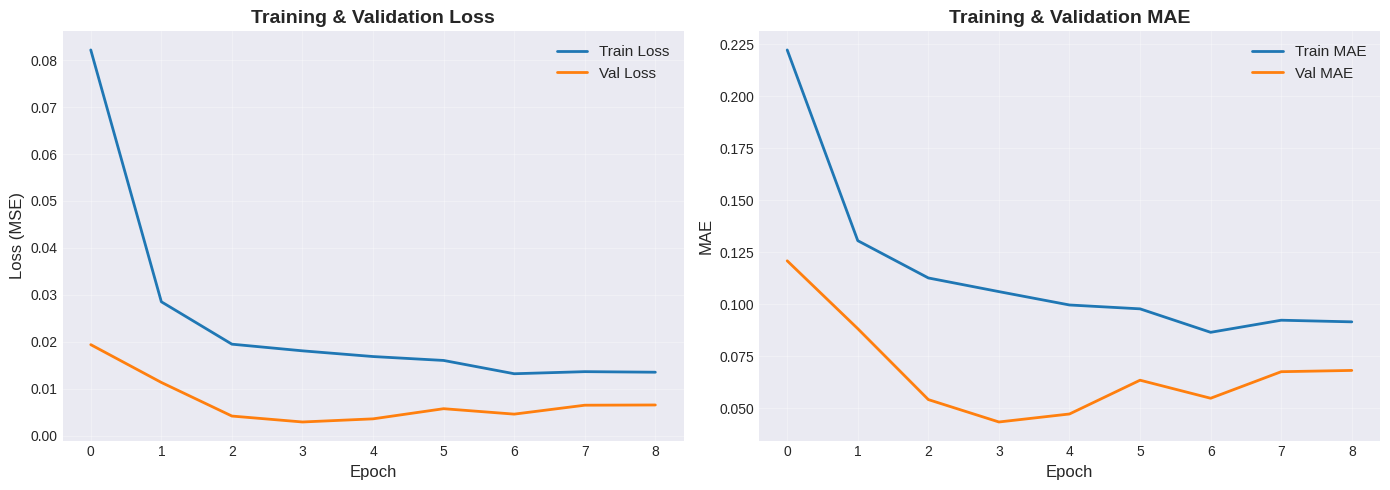

In [69]:
from step5_visualization import plot_training_history

plot_training_history(history)

---

## 📊 BƯỚC 5: ĐÁNH GIÁ & VẼ BIỂU ĐỒ

### Giải thích:
- **MAE**: Sai số trung bình tuyệt đối (USD)
- **RMSE**: Căn bậc 2 của sai số bình phương trung bình (USD)
- **MAPE**: Sai số phần trăm trung bình (%)

In [70]:
from step4_training import evaluate_model, print_sample_predictions, calculate_direction_accuracy
from step5_visualization import plot_predictions, plot_all_in_one

# Đánh giá trên test set
eval_result = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    scaler=scaler,
    return_predictions=True
)

# Lấy dự đoán và giá trị thật
y_true = eval_result['y_true']
y_pred = eval_result['predictions']


📊 KẾT QUẢ ĐÁNH GIÁ TRÊN TEST SET
MAE:  $1250.65  (Sai số trung bình tuyệt đối)
RMSE: $1669.36  (Căn bậc 2 sai số bình phương)
MAPE: 1.39%  (Sai số phần trăm trung bình)



In [71]:
# In một số ví dụ dự đoán
print_sample_predictions(y_true, y_pred, n_samples=10)


VÍ DỤ DỰ ĐOÁN (đầu 10 mẫu)
STT   Thực tế         Dự đoán         Sai số          % Sai số  
------------------------------------------------------------
1     $90384.55      $88047.67      $2336.88       2.59     %
2     $92707.51      $88120.85      $4586.66       4.95     %
3     $93800.83      $88368.02      $5432.81       5.79     %
4     $92678.80      $88651.55      $4027.25       4.35     %
5     $92410.62      $88868.25      $3542.37       3.83     %
6     $92782.91      $89041.44      $3741.47       4.03     %
7     $92120.45      $89208.68      $2911.77       3.16     %
8     $92063.69      $89306.73      $2756.96       2.99     %
9     $92957.67      $89404.07      $3553.60       3.82     %
10    $92015.37      $89537.75      $2477.62       2.69     %



In [72]:
# Tính độ chính xác xu hướng
calculate_direction_accuracy(y_true, y_pred)

📈 Độ chính xác xu hướng: 47.19%


np.float64(0.47191011235955055)

### Vẽ biểu đồ predictions vs actual

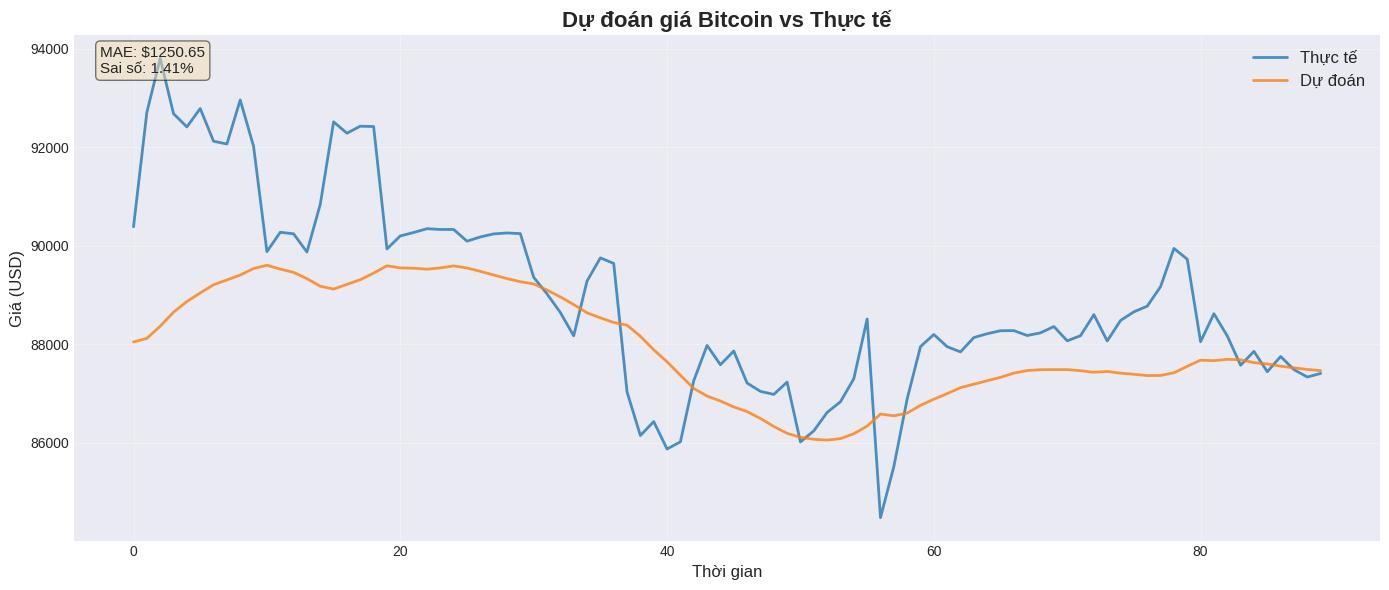

In [73]:
plot_predictions(y_true, y_pred)

### Vẽ biểu đồ tổng hợp (all-in-one)

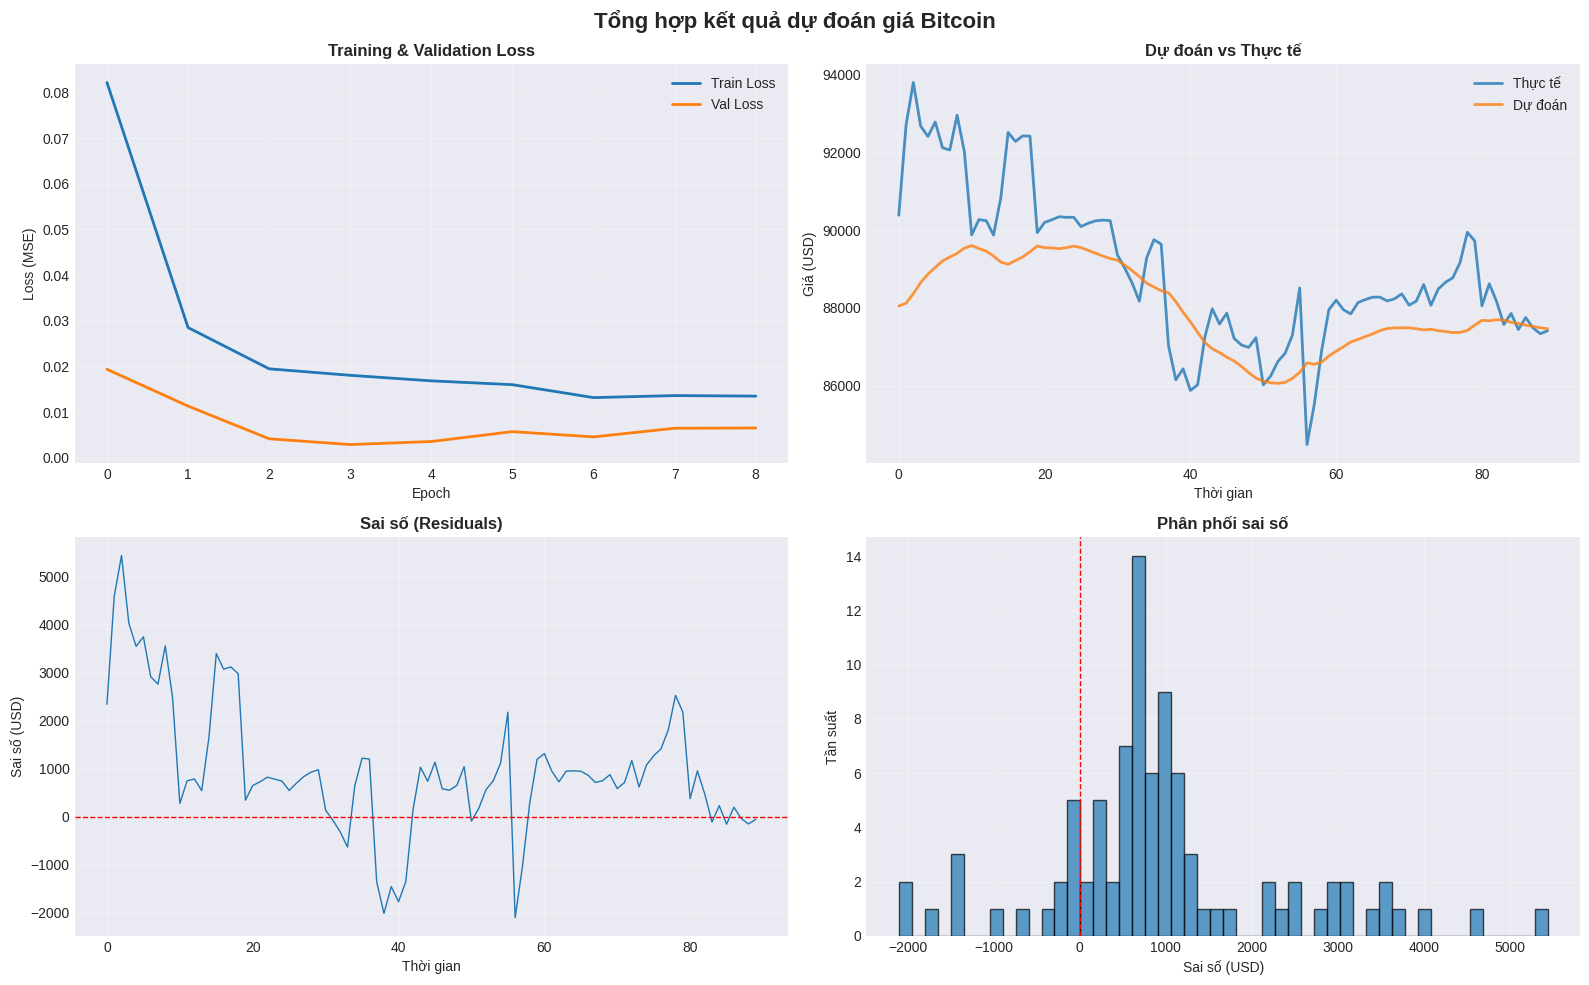

In [74]:
plot_all_in_one(history, y_true, y_pred)

---

## 💾 LƯU KẾT QUẢ

Tất cả kết quả được lưu vào thư mục `reports/notebook/`

📁 Folder kết quả: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251224_111300

💾 Đã lưu training history plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251224_111300/training_history_20251224_111300.png


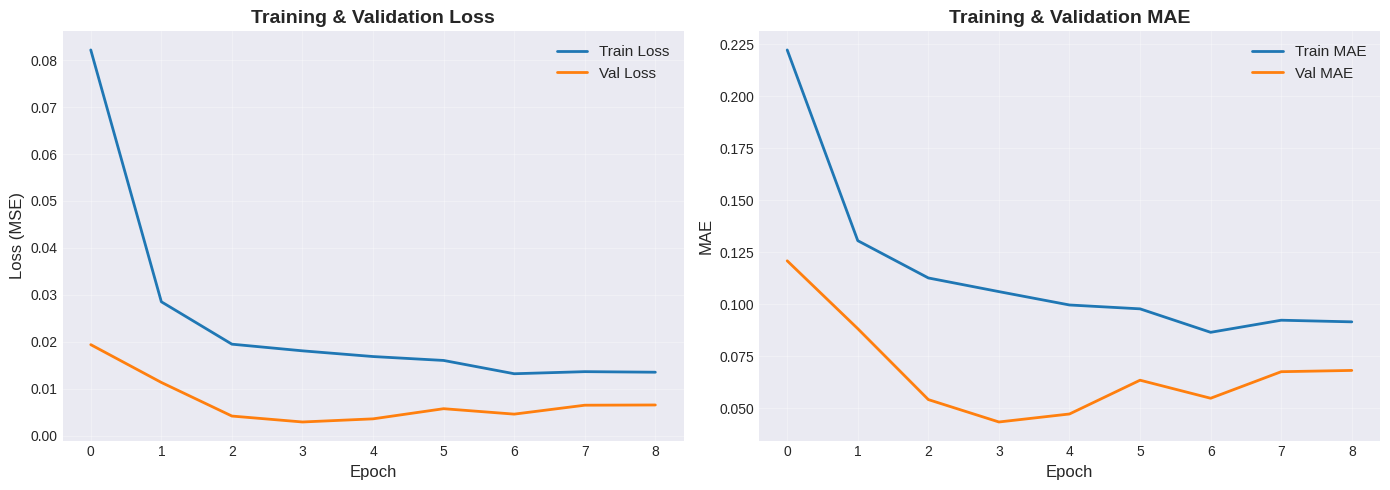

💾 Đã lưu predictions plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251224_111300/predictions_20251224_111300.png


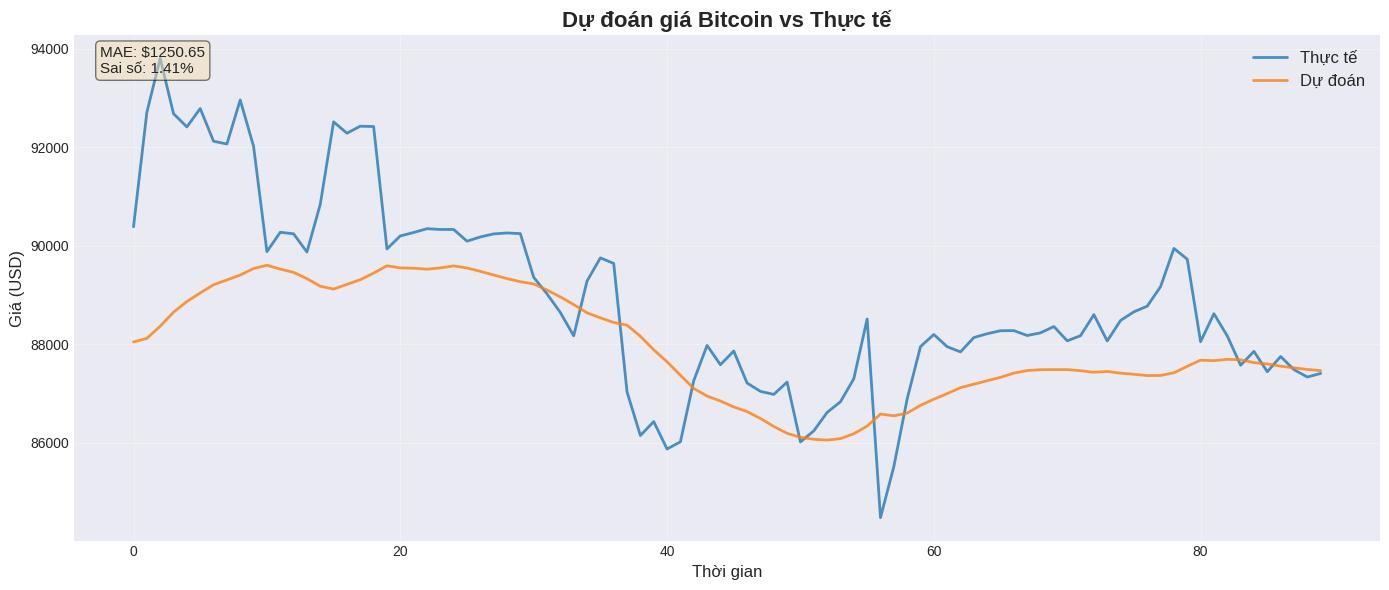

💾 Đã lưu all-in-one plot: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251224_111300/all_in_one_20251224_111300.png


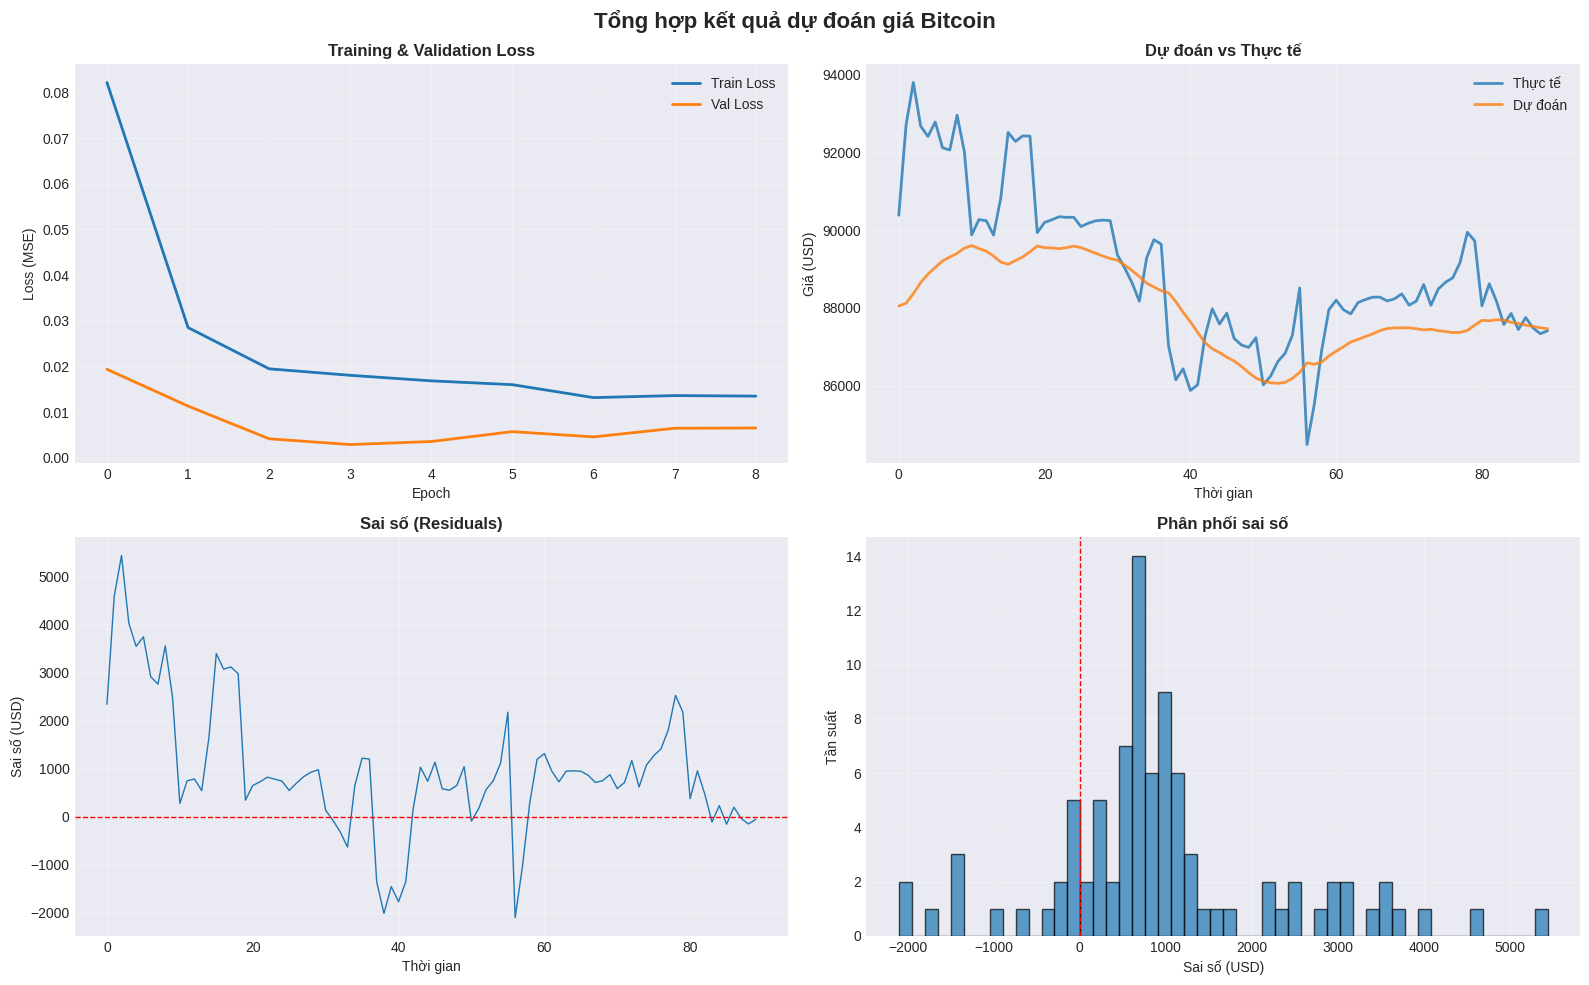

💾 Đã lưu báo cáo Markdown: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251224_111300/results_BiLSTM_20251224_111300.md
💾 Đã lưu cấu hình: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251224_111300/config.json
💾 Đã lưu metrics: /home/ultimatebrok/Downloads/deep_learning/reports/notebook/BiLSTM_20251224_111300/metrics.json

✅ Bước 5 hoàn thành!


In [75]:
from utils import create_results_folder, save_markdown_report, save_config, save_metrics

# Tạo folder kết quả
results_folder = create_results_folder(run_type="notebook")
print(f"📁 Folder kết quả: {results_folder}\n")

# Tạo suffix cho tên file
timestamp_suffix = results_folder.name.replace('BiLSTM_', '')

# Vẽ và lưu biểu đồ
plot_history_file = results_folder / f"training_history_{timestamp_suffix}.png"
plot_predictions_file = results_folder / f"predictions_{timestamp_suffix}.png"
plot_all_in_one_file = results_folder / f"all_in_one_{timestamp_suffix}.png"

plot_training_history(history, save_path=str(plot_history_file))
plot_predictions(y_true, y_pred, save_path=str(plot_predictions_file))
plot_all_in_one(history, y_true, y_pred, save_path=str(plot_all_in_one_file))

# Chuẩn bị config và metrics
config_dict = {
    'symbol': SYMBOL,
    'timeframe': TIMEFRAME,
    'limit': LIMIT,
    'window_size': WINDOW_SIZE,
    'features': FEATURES,
    'lstm_units': LSTM_UNITS,
    'dropout_rate': DROPOUT_RATE,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'early_stopping_patience': EARLY_STOPPING_PATIENCE
}

plots_dict = {
    'training_history': timestamp_suffix,
    'predictions': timestamp_suffix,
    'all_in_one': timestamp_suffix
}

# Lưu báo cáo
save_markdown_report(
    folder_path=results_folder,
    config=config_dict,
    metrics=eval_result,
    history=history.history,
    plots=plots_dict
)
save_config(results_folder, config_dict)
save_metrics(results_folder, eval_result)

# Đánh dấu checklist
print("\n✅ Bước 5 hoàn thành!")

---

## 🎉 HOÀN THÀNH!

### Checklist:
- [x] Bước 1: Lấy dữ liệu từ Binance
- [x] Bước 2: Xử lý dữ liệu
- [x] Bước 3: Xây dựng model BiLSTM
- [x] Bước 4: Training model
- [x] Bước 5: Đánh giá & Vẽ biểu đồ

### Kết quả:
- Báo cáo Markdown: `reports/notebook/BiLSTM_YYYYMMDD_HHMMSS/results_*.md`
- Biểu đồ: Các file PNG trong cùng folder
- Config & Metrics: File JSON trong cùng folder

### Tiếp theo:
- Thử thay đổi các tham số (window size, LSTM units, v.v.)
- Thêm các features khác (volume, open, high, low)
- Thử timeframe khác (4h, 1h)

**Chúc bạn thành công! 🚀**